## SMS Text Classification using Neural Networks
---

Here, we create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

We shall create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list will be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list will be the word "ham" or "spam", depending on which is most likely.

For this project, we will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests the model and function.


In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

     |████████████████████████████████| 390.3MB 46kB/s 
     |████████████████████████████████| 460kB 56.7MB/s 
     |████████████████████████████████| 10.2MB 53.9MB/s 
2.4.0-dev20200918


In [2]:
# get data files
TRAIN_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/train-data.tsv"
TEST_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/valid-data.tsv"


Reading both training and test data from the URLs into respective dataframes.


In [3]:
train_messages = pd.read_csv(TRAIN_DATA_URL, sep ='\t',names=["label", "message"])

test_messages = pd.read_csv(TEST_DATA_URL, sep ='\t',names=["label", "message"])

In [4]:
print("Size of training set:", train_messages.shape)
print("Size of test set:", test_messages.shape)

Size of training set: (4179, 2)
Size of test set: (1392, 2)


In [5]:
train_messages.head()

,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [6]:
train_messages.describe()

,label,message
count,4179,4179
unique,2,3935
top,ham,"sorry, i'll call later"
freq,3619,22


Mapping ham label as 0 and spam as 1

In [7]:
train_messages['msg_type']= train_messages['label'].map({'ham': 0, 'spam': 1})
train_msg = train_messages['message']
train_labels = train_messages['msg_type'].values

test_messages['msg_type']= test_messages['label'].map({'ham': 0, 'spam': 1})
test_msg = test_messages['message']
test_labels = test_messages['msg_type'].values



##Text Preprocessing
---

### Tokenization

Using the Tokenizer API to split sentences into words and encode them into integers. This is done to convert text into numerical data.

In [8]:
# Defining pre-processing hyperparameters
max_len = 50
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>"  #out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words during text_to_sequence calls 
vocab_size = 700

In [9]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [ ]:
# Get the word index 
word_index = tokenizer.word_index
word_index

In [12]:
# check how many unique words are in the training data
tot_words = len(word_index)
print('No. of unique tokens in training data: %s ' % tot_words)


No. of unique tokens in training data: 7693 


###Sequencing and Padding
---

After tokenization, we represent each sentence by sequences of numbers using texts_to_sequences() from tokenizer object. Subsequently, we use pad_sequences() so that each sequence will have same length.

In [13]:
training_seq = tokenizer.texts_to_sequences(train_msg)
training_padded = keras.preprocessing.sequence.pad_sequences(training_seq, maxlen=max_len, 
                                                             padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(test_msg)
test_padded = keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_len, 
                                                             padding=padding_type, truncating=trunc_type)

In [14]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', test_padded.shape)

Shape of training tensor:  (4179, 50)
Shape of testing tensor:  (1392, 50)


## Creating a Dense Model

First, we create a Dense Model using Keras' Sequential model.

The first layer i.e. the Embedding layer maps each word to an N-dimensional vector of real numbers. The embeding_dim is the size of this vector. The embedding layer indicates that the two words with a similar meaning tend to have very close vectors.

The Pooling layer helps to reduce the number of parameters in the model hence helps to avoid overfitting.

In [15]:
embedding_dim = 18

In [16]:
from keras import layers

model_dense = tf.keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim,input_length=max_len),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(24, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1,activation='sigmoid')])

model_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 18)            12600     
_________________________________________________________________
dropout (Dropout)            (None, 50, 18)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                456       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 13,081
Trainable params: 13,081
Non-trainable params: 0
____________________________________________________

The model.summary(),  provides the layer, shape and number of parameters used in each layer.

In the embedding layer, the **12600** parameter comes from 500 words (vocab_size), each one with a 16 dimensional word-vector space (**700 X 18 =12600**). 

The embedding layer is passed through GlobalAveragePooling1D and into dense layers have shape of 18 (due to the average pooling along 18 embedding dimension). We selected 24 neurons for the dense hidden layer. Each of the 24 neurons in the dense layer gets input from each of the 18 values coming from the GlobalAveragePooling1D layer, for a **total of 432 (18 X 24) weights and 24 biases** (one for each 24 neurons). 

Hence the total parameter is 456. Finally, the output layer has 24 weights (one for each neuron) and its one bias term resulting 25 parameters in total.

In [17]:
model_dense.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])


In [18]:
from keras.callbacks import EarlyStopping
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3) #stops training if validation performance doesn't improve after 3 epochs

history_dense = model_dense.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(test_padded,test_labels),callbacks=[early_stop], verbose=2)

Epoch 1/30
131/131 - 1s - loss: 0.5102 - accuracy: 0.8488 - val_loss: 0.3420 - val_accuracy: 0.8657
Epoch 2/30
131/131 - 0s - loss: 0.3001 - accuracy: 0.8660 - val_loss: 0.2481 - val_accuracy: 0.8657
Epoch 3/30
131/131 - 0s - loss: 0.2070 - accuracy: 0.8837 - val_loss: 0.1726 - val_accuracy: 0.9526
Epoch 4/30
131/131 - 0s - loss: 0.1419 - accuracy: 0.9572 - val_loss: 0.1137 - val_accuracy: 0.9713
Epoch 5/30
131/131 - 0s - loss: 0.0974 - accuracy: 0.9720 - val_loss: 0.0804 - val_accuracy: 0.9777
Epoch 6/30
131/131 - 0s - loss: 0.0709 - accuracy: 0.9801 - val_loss: 0.0676 - val_accuracy: 0.9777
Epoch 7/30
131/131 - 0s - loss: 0.0579 - accuracy: 0.9844 - val_loss: 0.0609 - val_accuracy: 0.9784
Epoch 8/30
131/131 - 0s - loss: 0.0501 - accuracy: 0.9852 - val_loss: 0.0549 - val_accuracy: 0.9799
Epoch 9/30
131/131 - 0s - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.0518 - val_accuracy: 0.9813
Epoch 10/30
131/131 - 0s - loss: 0.0391 - accuracy: 0.9880 - val_loss: 0.0487 - val_accuracy: 0.9828

In [19]:
model_dense.evaluate(test_padded, test_labels)

44/44 [==============================] - 0s 793us/step - loss: 0.0448 - accuracy: 0.9885


[0.04481029883027077, 0.9885057210922241]

We are getting a loss of 0.04 and an accuracy of **98.8%** in classifying messages as ham or spam using a dense network.

Plotting the training and validation loss and accuracy:

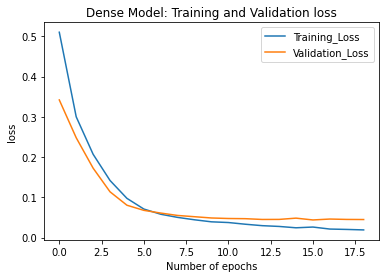

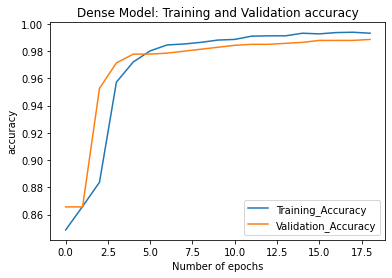

In [20]:
# Create a dataframe
metrics = pd.DataFrame(history_dense.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Create an LSTM(Long Short Term Memory) Model

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of Recurrent Neural Networks, capable of learning long-term dependencies.
These are important when the context of a long sentence is derived from a word early on in the sentence. That meaning may be lost in a simple RNN, but LSTM is capable of dealing with such long-term dependencies.

In [ ]:
model_LSTM = tf.keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim,input_length=max_len),
  layers.LSTM(20, dropout=0.2,return_sequences=True),
  layers.LSTM(20, dropout=0.2,return_sequences=True),
  layers.Dense(1,activation='sigmoid')])

model_LSTM.summary()


In [ ]:
model_LSTM.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)

history_LSTM = model_LSTM.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(test_padded,test_labels), callbacks=[early_stop], verbose=2)

Epoch 1/30
131/131 - 5s - loss: 0.2996 - accuracy: 0.9022 - val_loss: 0.1510 - val_accuracy: 0.9548
Epoch 2/30
131/131 - 5s - loss: 0.1232 - accuracy: 0.9663 - val_loss: 0.1164 - val_accuracy: 0.9680
Epoch 3/30
131/131 - 5s - loss: 0.0936 - accuracy: 0.9743 - val_loss: 0.0987 - val_accuracy: 0.9724
Epoch 4/30
131/131 - 5s - loss: 0.0769 - accuracy: 0.9784 - val_loss: 0.0929 - val_accuracy: 0.9739
Epoch 5/30
131/131 - 5s - loss: 0.0701 - accuracy: 0.9795 - val_loss: 0.0869 - val_accuracy: 0.9751
Epoch 6/30
131/131 - 5s - loss: 0.0636 - accuracy: 0.9816 - val_loss: 0.0815 - val_accuracy: 0.9771
Epoch 7/30
131/131 - 5s - loss: 0.0620 - accuracy: 0.9813 - val_loss: 0.0826 - val_accuracy: 0.9758
Epoch 8/30
131/131 - 5s - loss: 0.0550 - accuracy: 0.9832 - val_loss: 0.0869 - val_accuracy: 0.9746


In [ ]:
model_LSTM.evaluate(test_padded, test_labels)

44/44 [==============================] - 0s 8ms/step - loss: 0.0869 - accuracy: 0.9746


[0.08689868450164795, 0.9745544195175171]

We are getting a loss of 0.08 and accuracy of 97.4% using an LSTM model. This is slightly lesser than the dense network.

Plotting the training and validation loss and accuracy:

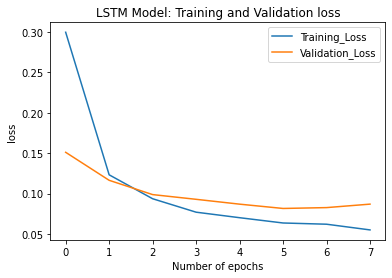

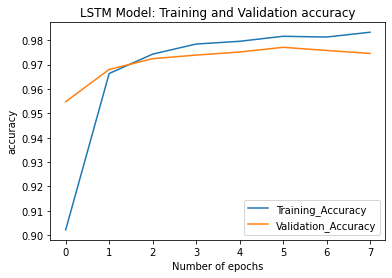

In [ ]:
# Create a dataframe
metrics_LSTM = pd.DataFrame(history_LSTM.history)
# Rename column
metrics_LSTM.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs2(var1, var2, string):
    metrics_LSTM[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs2('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs2('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Create a function to predict message labels:

As the dense network performed better, we shall use the dense model to predict the labels of new messages.

We create a function that takes a text message as an argument and outputs the probability of it being spam and the label.

In [22]:
# function to predict messages based on model
# returns list containing prediction and label, ex. [0.008318834938108921, 'ham']
from keras.preprocessing.sequence import pad_sequences

def predict_message(pred_text):
    prediction = []
    new_seq = tokenizer.texts_to_sequences([pred_text])
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    prediction_prob = model_dense.predict(padded)[0][0]
    prediction.append(prediction_prob)
    if prediction_prob>0.5:
      prediction.append('spam')
    
    else:
      prediction.append('ham')

    return (prediction)


pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.0008110106, 'ham']


In [24]:
# Run this cell to test function and model.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    print(prediction)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("Test passed. Function predicted all message labels correctly")
  else:
    print("Test fail: Function failed to predict one or more message labels correctly")
  

test_predictions()


[0.0008110106, 'ham']
[0.53934026, 'spam']
[0.00014469028, 'ham']
[0.9890735, 'spam']
[0.9966333, 'spam']
[0.00013765693, 'ham']
[0.0006105304, 'ham']
Test passed. Function predicted all message labels correctly
